<a href="https://colab.research.google.com/github/stefanogiagu/AI_in_MI_course_2023/blob/main/notebooks/AIinMI_2023_HandsOn_xAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI in Medical Image Analysis 2023
## Hands-on session on xAI

In this example, we implement some classical xAI techniques for the explainability of a ConvNet architecture trained for a classification task in medial imaging. 

Task: explainability of prediction of a CNN model trained for medical images (dermatoscopic images) classification 


**Dataset:** <p>
The dataset is the *HAM10000 (isic2018)* ([link](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T)). The HAM 10000 dataset is a collection of 10015 dermatoscopic images obtained from the Medical University of Vienna, Austria, and the Cliff Rosendahl Skin Cancer Practice in Queensland Australia over the period of two years (Tschandl, Rosendahl, and Kittler 2018). Initial images from the Australia site were stored in Powerpoint files, while the Austrian images were stored as diapositives. Images were digitized with a two-fold scan, and stored as 8-bit JPEG images at 300DPI; 15x10cm. Images were then manually cropped with the lesion centered to 800x600 px at 82DPI. 

The images contains representative cases of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

In the HAM 10000 dataset the images are categorized in 7 classes, highly unbalanced (with one class representing about 70% of the whole dataset). After a partial rebalancing we endup with an effective dataset of 5275 images.


**CNN Architecture:** <p>

We use a pretrained convnet (DenseNet121) from pytorch library, pre-trained on ImageNet and fine tuning it to our dataset/task

**xAI Tools:** <p>

We use the *CAPTUM* library: [link](hhttps://captum.ai), a popular open source and extensible library for model explainability and interpretability built on PyTorch.

In the hands-on we implement some of examples of *attribution methods*: *[Occlusion](https://arxiv.org/abs/1311.2901), [GradCAM](https://arxiv.org/abs/1610.02391), and [Integrated Gradient](https://arxiv.org/abs/1703.01365)*.

For infos, latest version of the notebook, etc., contact Stefano Giagu: email: <stefano.giagu@uniroma1.it>, web: [https://www.giagu.it](https://www.giagu.it) 

In [ ]:
# Download HAM10000 dataset

!rm -rf data
!rm -rf ISIC2018*
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip
!unzip -q ISIC2018_Task3_Training_Input.zip
!unzip -q ISIC2018_Task3_Training_GroundTruth.zip

--2023-05-20 10:52:03--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.78.92, 52.217.133.33, 52.217.12.84, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.78.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2771732744 (2.6G) [application/zip]
Saving to: ‘ISIC2018_Task3_Training_Input.zip’

ISIC2018_Task3_Trai 100%[===================>]   2.58G  34.1MB/s    in 79s     

2023-05-20 10:53:23 (33.3 MB/s) - ‘ISIC2018_Task3_Training_Input.zip’ saved [2771732744/2771732744]

--2023-05-20 10:53:23--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.57.81, 52.216.43.17, 52.216.38.137, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-chal

In [ ]:
# rebalance and organize the images in a folder structure suitable to be read with the torchvision.datasets.ImageFolder api

import numpy as np
import pandas as pd

df = pd.read_csv('/content/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')
labels = df.to_numpy()

import os
import shutil

for i in range(7):
  os.makedirs('/content/data/'+str(i))


# to balance classes
cfrac = [0.1111333 , 0.66949576, 0.05132302, 0.03265102, 0.1097354 , 0.01148278, 0.01417873]

for i in range(labels.shape[0]):
  lab = np.argmax(labels[i,1:])

  rnd = np.random.rand()
  if rnd >= cfrac[lab]:
    shutil.copyfile('/content/ISIC2018_Task3_Training_Input/'+labels[i,0]+'.jpg', '/content/data/'+str(lab)+'/'+labels[i,0]+'.jpg') 

In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import glob

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

import torch.nn as nn
import torch.nn.functional as F

2.0.1+cu118
0.15.2+cu118


In [ ]:
# read data with torchvision 

from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
import PIL


data_dir = 'data'

# as we will process the input using a pretrained densnet121 model, pretrained on ImageNet we need to apply the same transformation 
# used for ImagaNet:
# - the images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]
# - finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

train_transforms = # ... TO WRITE


# inverse transformation to normalize back to the original images (inv_tensor = invTrans(input_tensor))

invTrans = # ... TO WRITE

# torchvision.datasets.ImageFolder function allows to read a dataset from a folder structure and associate to events labels on the base of the 
# subfolders' name containing the images 
# see https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

print(dataset)

# split dataset in training, validation and test 90:5:5 %
ev_train = int(len(dataset)*0.9)
ev_vali  = int(0.5*(len(dataset)-ev_train))
ev_test  = len(dataset) - ev_train - ev_vali
train_data, vali_data, test_data = torch.utils.data.random_split(dataset, [ev_train, ev_vali, ev_test])

print('Trainign set size: ', len(train_data))
print('Validation set size: ',len(vali_data))
print('Test set size: ',len(test_data))

# dataloaders 

batch_size = 128
train_loader =torch.utils.data.DataLoader (train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(vali_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

Dataset ImageFolder
    Number of datapoints: 5330
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Trainign set size:  4797
Validation set size:  266
Test set size:  267


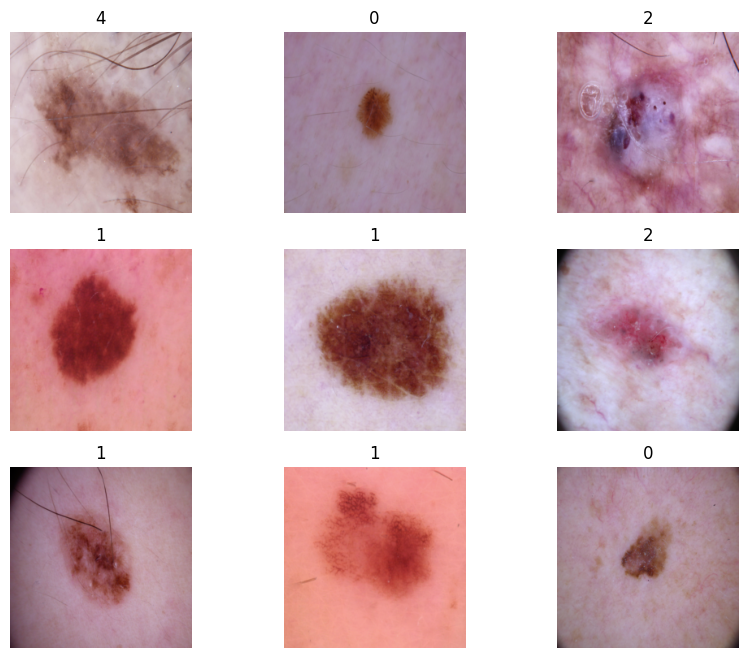

In [ ]:
# example of some of the images in the dataset

figure = plt.figure(figsize=(10, 8))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    img = invTrans(img) #normalize back the image to the original normalization
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0)) #note: imshow expect image shape as (h,w,channel) while torch uses (channel,h,w)
plt.show()

In [ ]:
# plot label frequencies in the dataset 
label = train_data.dataset.targets

(array([0.19136961, 0.42645403, 0.09212008, 0.05909944, 0.18348968,
        0.02157598, 0.02589118]),
 array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <BarContainer object of 7 artists>)

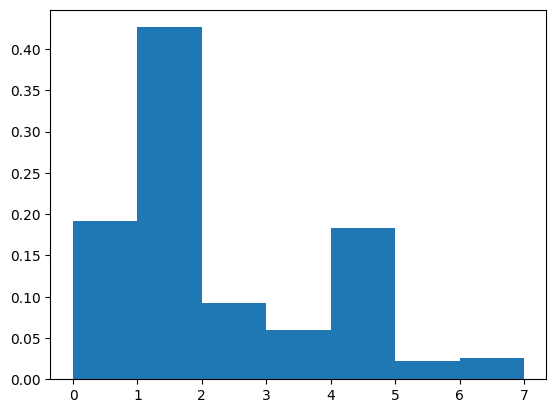

In [ ]:
plt.hist(label, bins=7, range=[0,7], density=True)

In [ ]:
# check GPU
if torch.cuda.is_available():
  print('Number of availabel GPUs: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(0))

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Number of availabel GPUs:  1
Tesla T4
Computation device: cuda



In [ ]:
# Load a pretrained torchvision model: densenet121

from torchvision import datasets, transforms, models

# esempio DenseNet121
model = # ... TO WRITE

print(model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 205MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# Transfer Learning step:

# 1 - freeze model weights

# ... TO WRITE

# replace the classifier head in the model with another MLP with 7 classes output 

# OrderedDict is just a more sophisticated version of the python dictionary that allows to remember th eorder 
# in which the elements have been added to the dictionary  
from collections import OrderedDict

classifier = # ... TO WRITE

model.classifier = classifier

In [ ]:
# test the model on one batch to check everything is fine ...

# ... TO WRITE

torch.Size([128, 7])
tensor([-0.0065,  0.0654, -0.1980,  0.0207, -0.2151,  0.2285, -0.1220],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
#install torchmetrics: collection of useful PyTorch metrics implementations and an easy-to-use API to create custom metrics
%pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 22.8 MB/s eta 0:00:00


In [ ]:
# loss and optmizer

loss_func = nn.CrossEntropyLoss() #cross entropy loss 

# metric accuracy 
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy

metric_func = MulticlassAccuracy(num_classes=7)
metric_func = metric_func.to(device) #NOTE: need to be moved in the device where the computation is done

# opitmizer: Adam
from torch import optim
LR_ST = 1e-3
opt = optim.Adam(model.parameters(), lr=LR_ST)

In [ ]:
# Training loop (~30' on colab with T4 GPU)

model.to(device)

import time

# number of epochs: 10 or 20 should be enough
epochs = 20

# python lists to record loss and metric vs epoch results
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

best_acc = 0.0

# loop over epochs
for epoch in range(epochs):
    t0 = time.time()
    
    # training step
    model.train()
    train_loss = 0
    train_metric = 0
    counter = 0

    for xb, yb in train_loader:
        counter += 1
        xb=xb.to(device) 
        yb=yb.to(device) 

        pred = model(xb) #prediction

        # loss and metric computation
        loss = loss_func(pred, yb)
        metric = metric_func(pred, yb)

        # update total loss/metric 
        train_loss += loss.item()
        train_metric += metric.item()

        # backpropagation
        opt.zero_grad() 
        loss.backward() 
        opt.step()


    train_loss /= counter
    train_metric /= counter
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    # validation step 
    model.eval()
    vali_loss = 0
    vali_metric = 0
    counter = 0
    with torch.no_grad(): 
      for xb, yb in val_loader:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        pred = model(xb) 

        vloss = loss_func(pred, yb)
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()  

    vali_loss /= counter
    vali_metric /= counter
    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    if vali_metric >= best_acc:
      print('Validation accuracy improved from ',best_acc, ' to ', vali_metric, ' model saved')
      torch.save(model, './resnet50_model.pt')
      best_acc = vali_metric

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" 
          % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))

epoch: 1, time(s): 82.9752, train loss: 1.446847, train metric: 0.180549, vali loss: 1.324778, vali metric: 0.262869
epoch: 2, time(s): 81.7696, train loss: 1.140968, train metric: 0.298492, vali loss: 1.110605, vali metric: 0.283931
epoch: 3, time(s): 82.5368, train loss: 0.993905, train metric: 0.366864, vali loss: 1.051739, vali metric: 0.409033
epoch: 4, time(s): 81.4938, train loss: 0.911076, train metric: 0.435661, vali loss: 0.939261, vali metric: 0.539113
epoch: 5, time(s): 81.7986, train loss: 0.863842, train metric: 0.479388, vali loss: 0.926141, vali metric: 0.463337
epoch: 6, time(s): 81.8453, train loss: 0.813400, train metric: 0.519908, vali loss: 0.923000, vali metric: 0.533775
epoch: 7, time(s): 81.4222, train loss: 0.790315, train metric: 0.561380, vali loss: 0.891391, vali metric: 0.474737
epoch: 8, time(s): 82.7894, train loss: 0.763945, train metric: 0.567569, vali loss: 0.851372, vali metric: 0.559974
epoch: 9, time(s): 91.7723, train loss: 0.731454, train metric: 

In [ ]:
# load best model

model = torch.load('./resnet50_model.pt')

In [ ]:
# install captum library
!pip install captum

# note: to use plotting features of caputm we need to downgrade matplotlib on colab
!pip uninstall matplotlib
!pip install matplotlib==3.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: matplotlib 3.7.1
Uninstalling matplotlib-3.7.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/matplotlib-3.7.1-py3.10-nspkg.pth
    /usr/local/lib/python3.10/dist-packages/matplotlib-3.7.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/matplotlib/*
    /usr/local/lib/python3.10/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.10/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.10/dist-packages/pylab.py
Proceed (Y/n)? ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: matplo

In [ ]:
# take one validation event as example
feat, label = next(iter(val_loader))

id_ev = 33
input = feat[id_ev]
lab   = label[id_ev]

input = input.unsqueeze(0) # add the batch dimension

In [ ]:
lab_pred = torch.argmax(model(input)).item()

print('True label: ', lab.item(), '  / predicted label: ', lab_pred)

True label:  4   / predicted label:  4


In [ ]:
# explainability by attributions: Occlusion Method

# perturbation based approach to compute attribution, involving
# replacing each contiguous rectangular region of the image with a given baseline /
# reference, and computing the difference in output. 
# The first patch is applied with the corner aligned with all indices 0,
# and strides are applied until the entire dimension range is covered.

from captum.attr import Occlusion
from captum.attr import visualization as viz

In [ ]:
occlusion = # ... TO WRITE

input = input.to(device)
lab = lab.to(device)

attributions_occ = # ... TO WRITE

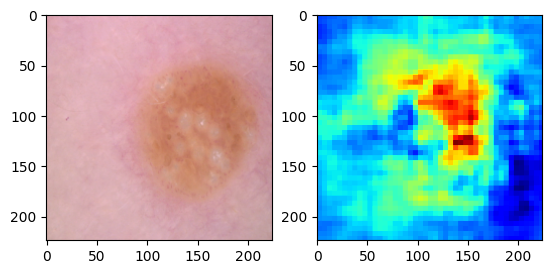

In [ ]:
# plot by hands the hit-map and original image

heat_map = np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0))

plt.subplot(1,2,1)
plt.imshow(np.transpose(invTrans(input.squeeze().cpu()).detach().numpy(), (1,2,0)))
plt.subplot(1,2,2)
plt.imshow(heat_map[:,:,0], cmap='jet')

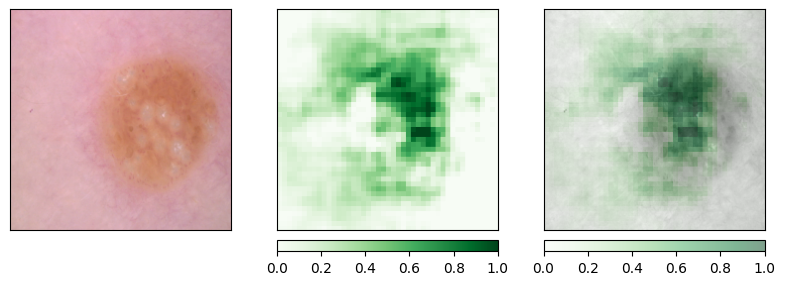

In [ ]:
# output plot of the heat-map using captum API
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(invTrans(input.squeeze().cpu()).detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "blended_heat_map"],
                                      ["all", "positive", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

In [ ]:
# explainability by attributions: LayerGradCAM

# Computes GradCAM attribution for chosen layer. GradCAM is designed for
# convolutional neural networks, and is usually applied to the last
# convolutional layer.
# GradCAM computes the gradients of the target output with respect to
# the given layer, averages for each output channel (dimension 2 of
# output), and multiplies the average gradient for each channel by the
# layer activations. The results are summed over all channels.

from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

In [ ]:
model.eval()

# set inplace False for all the ReLU functions in the model (required by captum)
for module in model.modules():
    if isinstance(module, torch.nn.ReLU):
        module.inplace=False

In [ ]:
# save and print all layers of the model to find the last convolutional layer

# ... TO WRITE

0 :      Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
1 :      BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2 :      ReLU()
3 :      MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4 :      _DenseBlock(
  (denselayer1): _DenseLayer(
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer2): _DenseLayer(
    (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

In [ ]:
# GradCam

gcam = # ... TO WRITE

attributions_gcam = # ... TO WRITE

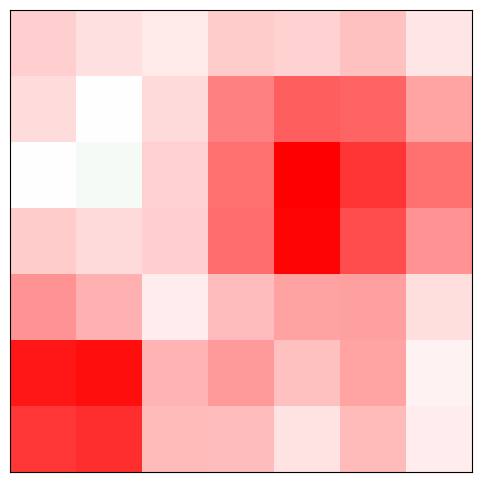

In [ ]:
_ = viz.visualize_image_attr(np.transpose(attributions_gcam.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                             sign="all",
                             )

In [ ]:
print(attributions_gcam.shape)
print(input.shape)

torch.Size([1, 1, 7, 7])
torch.Size([1, 3, 224, 224])


torch.Size([1, 1, 224, 224])


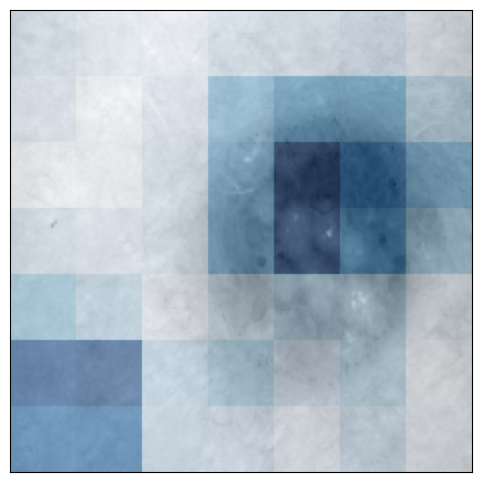

In [ ]:
# plot results

# interpolate the attribution to the original image shape

upsamp_attributions_gcam = # ... TO WRITE

print(upsamp_attributions_gcam.shape)


_ = viz.visualize_image_attr(np.transpose(upsamp_attributions_gcam.squeeze(0).cpu().detach().numpy(), (1,2,0)), 
                             np.transpose(invTrans(input.squeeze().cpu()).detach().numpy(), (1,2,0)),
                             method="blended_heat_map",
                            )

In [ ]:
# explainability by attributions: IntegratedGradients

# Integrated Gradients assigns an importance score to each input feature by approximating 
# the integral of the gradients of the model’s output with respect to the inputs.

# Integrated Gradients approximate the integral of gradients of the model's output with 
# respect to the inputs along the path (straight line) from given baselines / references to inputs.
# Baselines can be provided as input arguments to attribute method.

from captum.attr import IntegratedGradients, LayerAttribution
from captum.attr import visualization as viz

In [ ]:
integrated_gradients = # ... TO WRITE

model.zero_grad()
attributions_ig, _ = # ... TO WRITE

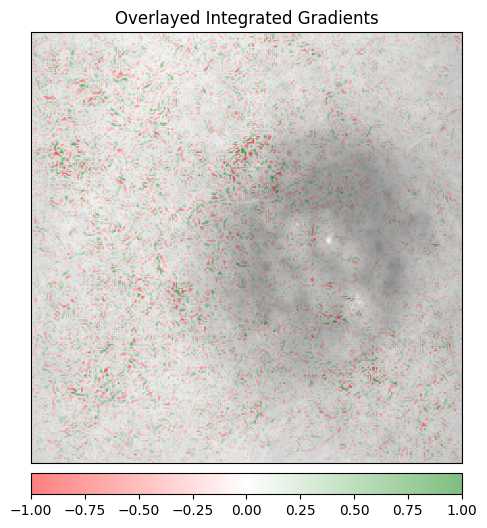

In [ ]:
_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(invTrans(input.squeeze().cpu()).detach().numpy(), (1,2,0)),
                             method="blended_heat_map",sign="all",
                             show_colorbar=True, title="Overlayed Integrated Gradients")

**Influencial examples method: TracIN**

Reference: [TracIN](https://arxiv.org/pdf/2002.08484.pdf).

Suggested tutorial: [CAPTUM tutorial](https://captum.ai/tutorials/TracInCP_Tutorial)